<div align='center'><font face='Comic Sans MS' size=7 color='green'><b><u>CIFAR-10 Image Classification Using CNNs</u></b></font></div>

### Objective
The objective of this assignment is to build a foundational understanding of Convolutional Neural Networks (CNNs) through practical implementation on the CIFAR-10 image classification task. This involves exploring and preparing data, designing and training a CNN model, evaluating its performance with metrics and visualizations, and experimenting with improvements to enhance accuracy and generalization.

In [30]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle

# TensorFlow and Keras components
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


## 1. Data Exploration and Preparation
The CIFAR-10 dataset containing 60,000 color images across 10 classes was loaded. Sample images and labels were displayed to gain initial familiarity with the data. Dataset shapes and class distributions were examined to ensure balance and correctness. Images were normalized to the range for better training stability. The dataset was split into 80% for training and 20% for validation to support effective model evaluation.

### 1.1 Dataset loading and sample display

In [22]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [16]:
# Print dataset shapes
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


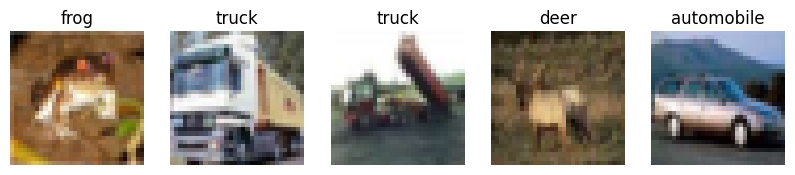

In [17]:
# CIFAR-10 label names
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display 5 sample images with labels
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(label_names[y_train[i][0]])
    plt.axis('off')
plt.show()



### 1.2 Target Column 

Label counts in training data:
airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


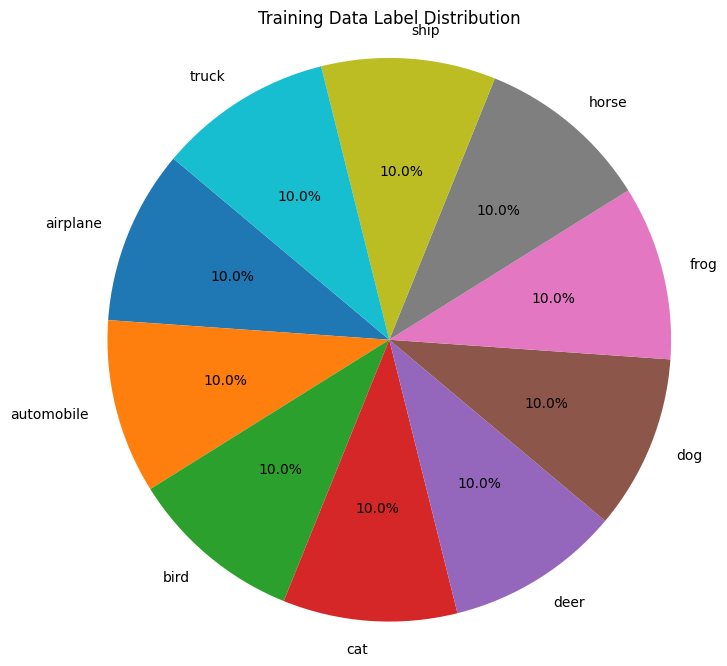

In [19]:

# Assume you have label_names and y_train ready
unique, counts = np.unique(y_train, return_counts=True)

# Print label counts
print("Label counts in training data:")
for label, count in zip(unique, counts):
    print(f"{label_names[label]}: {count}")

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=[label_names[i] for i in unique], autopct='%1.1f%%', startangle=140)
plt.title('Training Data Label Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()


### 1.3 Image Normalization

In [6]:
# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

# Print shapes after splitting
print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Test set shape:", x_test.shape)


Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


### 1.4 Sample Images

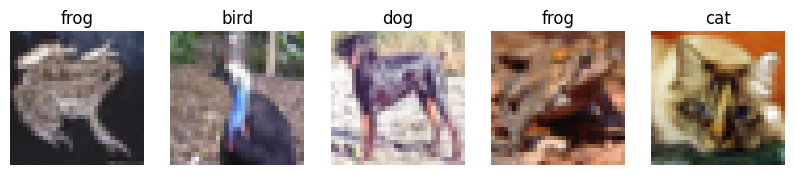

In [21]:
# Display 5 sample normalized images with labels
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i])  # Normalized images still display correctly with plt.imshow
    plt.title(label_names[y_train[i][0]])
    plt.axis('off')
plt.show()


### 1.5 Original image v/s normalized image

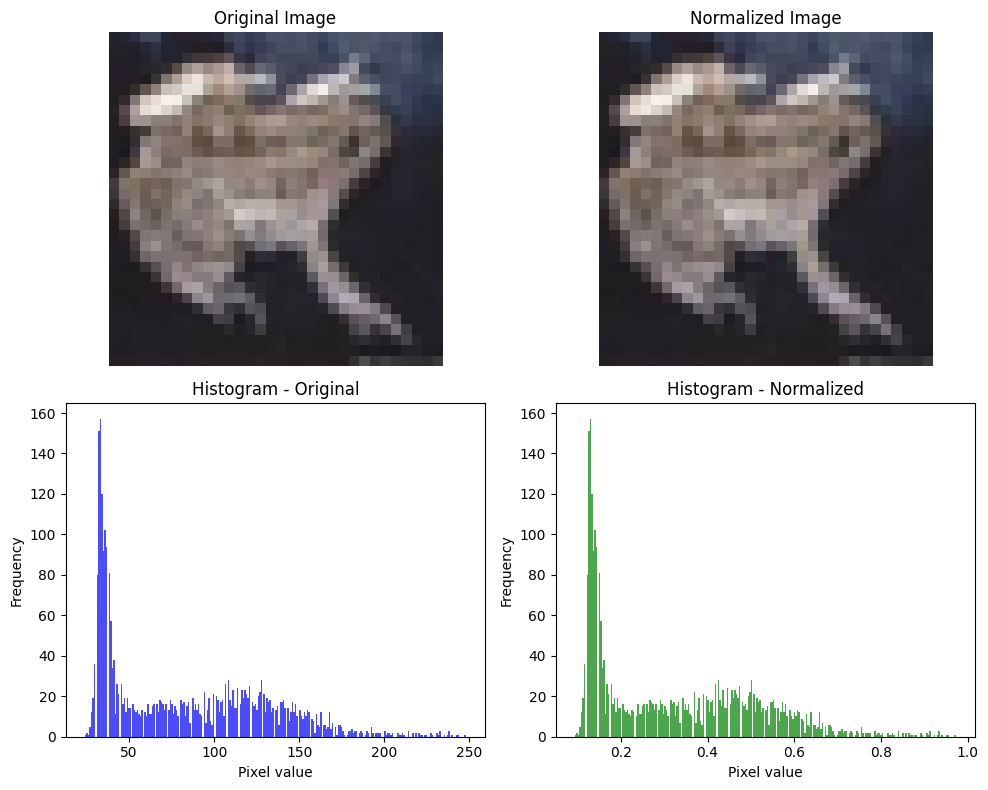

In [22]:
# Let's take the first image as sample

# Original image before normalization 
x_train_orig = x_train * 255  # If original not saved, rescale normalized back for demo (approximate)

sample_img_orig = x_train_orig[0]
sample_img_norm = x_train[0]

plt.figure(figsize=(10,8))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(sample_img_orig.astype('uint8'))
plt.title("Original Image")
plt.axis('off')

# Normalized image
plt.subplot(2, 2, 2)
plt.imshow(sample_img_norm)
plt.title("Normalized Image")
plt.axis('off')

# Histogram original
plt.subplot(2, 2, 3)
plt.hist(sample_img_orig.ravel(), bins=256, color='blue', alpha=0.7)
plt.title("Histogram - Original")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')

# Histogram normalized
plt.subplot(2, 2, 4)
plt.hist(sample_img_norm.ravel(), bins=256, color='green', alpha=0.7)
plt.title("Histogram - Normalized")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


- Normalization scales all image pixel values to a range between 0 and 1.

- This helps the neural network learn faster and more reliably by keeping inputs consistent.

- It prevents some input values from overpowering others and avoids numerical issues during training.



---
---

## 2. Modelling

In this project, we systematically train and evaluate five convolutional neural network (CNN) models to explore different architectures and optimization strategies for image classification on the CIFAR-10 dataset. Each model is named for clarity and to track progress:

1. Baseline Small CNN
> A simple, lightweight CNN with 3 convolutional blocks, pooling, and dropout layers to establish baseline performance.

2. Small CNN with SGD Optimizer
> The baseline architecture trained using the Stochastic Gradient Descent optimizer to compare training dynamics with other optimizers.

3. Small CNN with RMSprop Optimizer
> Same architecture trained with RMSprop to evaluate its effect on learning speed and accuracy.

4. Small CNN with Adam Optimizer
> The baseline CNN trained with the Adam optimizer, which combines adaptive learning rates and momentum for efficient training.

5. Custom Deep CNN
> A deeper CNN with batch normalization layers and increased filters per layer designed to improve feature extraction and generalization.

This structured approach allows comprehensive comparison between different optimizers on the small CNN baseline and identification of improvements brought by a deeper custom architecture.





In [45]:


# Build CNN model
model = Sequential()

# 1st Conv block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# 2nd Conv block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# 3rd Conv block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Fully connected layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  # 10 classes

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,418 (286.79 KB)

 Trainable params: 73,418 (286.79 KB)

 Non-trainable params: 0 (0.00 B)

### 2.1 Small_cnn

In [36]:

# Prepare labels
y_cat_train = to_categorical(y_train, num_classes=10)
y_cat_val = to_categorical(y_val, num_classes=10)

# Build the small CNN
small_cnn_model = Sequential()
small_cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
small_cnn_model.add(MaxPooling2D((2, 2)))
small_cnn_model.add(Dropout(0.25))

small_cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
small_cnn_model.add(MaxPooling2D((2, 2)))
small_cnn_model.add(Dropout(0.25))

small_cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
small_cnn_model.add(MaxPooling2D((2, 2)))
small_cnn_model.add(Dropout(0.25))

small_cnn_model.add(Flatten())
small_cnn_model.add(Dense(64, activation='relu'))
small_cnn_model.add(Dropout(0.5))
small_cnn_model.add(Dense(10, activation='softmax'))

small_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train small CNN
history_small = small_cnn_model.fit(
    x_train, y_cat_train,
    epochs=15,
    batch_size=64,
    validation_data=(x_val, y_cat_val),
    verbose=1
)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 60ms/step - accuracy: 0.2638 - loss: 1.9548 - val_accuracy: 0.4169 - val_loss: 1.6008
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.4006 - loss: 1.6181 - val_accuracy: 0.4990 - val_loss: 1.3868
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.4624 - loss: 1.4767 - val_accuracy: 0.5316 - val_loss: 1.3027
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.4954 - loss: 1.4017 - val_accuracy: 0.5499 - val_loss: 1.2500
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.5181 - loss: 1.3449 - val_accuracy: 0.5860 - val_loss: 1.1606
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.5418 - loss: 1.2911 - val_accuracy: 0.6080 - val_loss: 1.1054
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.5521 - loss: 1.2622 - val_accuracy: 0.6136 - val_loss: 1.0986
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.5685 - loss: 1.2265 - 

In [58]:
# Prepare test labels as one-hot encoded vectors like training labels
y_cat_test = to_categorical(y_test, num_classes=10)

# Evaluate the model on test data
test_loss_small, test_accuracy_small = small_cnn_model.evaluate(x_test, y_cat_test, verbose=1)

print(f"Test Loss: {test_loss_small:.4f}")
print(f"Test Accuracy: {test_accuracy_small:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6693 - loss: 0.9439
Test Loss: 0.9439
Test Accuracy: 0.6693


### 2.2 SGD model

In [25]:

# Build same CNN architecture as before
model_sgd = Sequential()

model_sgd.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_sgd.add(MaxPooling2D((2, 2)))
model_sgd.add(Dropout(0.25))

model_sgd.add(Conv2D(64, (3, 3), activation='relu'))
model_sgd.add(MaxPooling2D((2, 2)))
model_sgd.add(Dropout(0.25))

model_sgd.add(Conv2D(64, (3, 3), activation='relu'))
model_sgd.add(MaxPooling2D((2, 2)))
model_sgd.add(Dropout(0.25))

model_sgd.add(Flatten())
model_sgd.add(Dense(64, activation='relu'))
model_sgd.add(Dropout(0.5))
model_sgd.add(Dense(10, activation='softmax'))

# Compile with SGD optimizer
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)
model_sgd.compile(optimizer=sgd_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train model with SGD optimizer
history_sgd = model_sgd.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=1
)


C:\Users\kumku\anaconda3\envs\nlp_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.2042 - loss: 2.0885 - val_accuracy: 0.3531 - val_loss: 1.8122
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.3438 - loss: 1.7566 - val_accuracy: 0.4364 - val_loss: 1.5516
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.4108 - loss: 1.6136 - val_accuracy: 0.4827 - val_loss: 1.4396
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.4540 - loss: 1.5103 - val_accuracy: 0.5146 - val_loss: 1.3631
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.4775 - loss: 1.4482 - val_accuracy: 0.5439 - val_loss: 1.3104
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.4915 - loss: 1.4116 - val_accuracy: 0.5536 - val_loss: 1.2410
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.5123 - loss: 1.3637 - val_accuracy: 0.5402 - val_loss: 1.2736
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.5271 - loss: 1.3258 - 

In [59]:
# Evaluate the model on the test set
test_loss_sgd, test_accuracy_sgd = model_sgd.evaluate(x_test, y_test, verbose=1)

print(f'Test Loss: {test_loss_sgd:.4f}')
print(f'Test Accuracy: {test_accuracy_sgd:.4f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6343 - loss: 1.0490
Test Loss: 1.0490
Test Accuracy: 0.6343


### 2.3 RMS_prop Model

In [27]:

# Build same CNN architecture as before
model_rmsprop = Sequential()

model_rmsprop.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_rmsprop.add(MaxPooling2D((2, 2)))
model_rmsprop.add(Dropout(0.25))

model_rmsprop.add(Conv2D(64, (3, 3), activation='relu'))
model_rmsprop.add(MaxPooling2D((2, 2)))
model_rmsprop.add(Dropout(0.25))

model_rmsprop.add(Conv2D(64, (3, 3), activation='relu'))
model_rmsprop.add(MaxPooling2D((2, 2)))
model_rmsprop.add(Dropout(0.25))

model_rmsprop.add(Flatten())
model_rmsprop.add(Dense(64, activation='relu'))
model_rmsprop.add(Dropout(0.5))
model_rmsprop.add(Dense(10, activation='softmax'))

# Compile with RMSprop optimizer
rmsprop_optimizer = RMSprop(learning_rate=0.001)
model_rmsprop.compile(optimizer=rmsprop_optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Train model with RMSprop optimizer
history_rmsprop = model_rmsprop.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=1
)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.2589 - loss: 1.9710 - val_accuracy: 0.4085 - val_loss: 1.6221
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.3944 - loss: 1.6521 - val_accuracy: 0.4544 - val_loss: 1.5517
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.4566 - loss: 1.5065 - val_accuracy: 0.5288 - val_loss: 1.2909
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.4934 - loss: 1.4202 - val_accuracy: 0.5498 - val_loss: 1.2616
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.5205 - loss: 1.3515 - val_accuracy: 0.5703 - val_loss: 1.2031
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.5408 - loss: 1.3051 - val_accuracy: 0.5859 - val_loss: 1.1472
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.5528 - loss: 1.2717 - val_accuracy: 0.5981 - val_loss: 1.1519
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.5699 - loss: 1.2359 - 

In [28]:
# Evaluate RMSprop model
test_loss_rmsprop, test_accuracy_rmsprop = model_rmsprop.evaluate(x_test, y_test, verbose=1)
print(f'RMSprop Model - Test Loss: {test_loss_rmsprop:.4f}')
print(f'RMSprop Model - Test Accuracy: {test_accuracy_rmsprop:.4f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6828 - loss: 0.9367
RMSprop Model - Test Loss: 0.9367
RMSprop Model - Test Accuracy: 0.6828


### 2.4 ADAM Model

In [29]:

# Build the same CNN architecture as before
model_adam = Sequential()

model_adam.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_adam.add(MaxPooling2D((2, 2)))
model_adam.add(Dropout(0.25))

model_adam.add(Conv2D(64, (3, 3), activation='relu'))
model_adam.add(MaxPooling2D((2, 2)))
model_adam.add(Dropout(0.25))

model_adam.add(Conv2D(64, (3, 3), activation='relu'))
model_adam.add(MaxPooling2D((2, 2)))
model_adam.add(Dropout(0.25))

model_adam.add(Flatten())
model_adam.add(Dense(64, activation='relu'))
model_adam.add(Dropout(0.5))
model_adam.add(Dense(10, activation='softmax'))

# Compile with Adam optimizer
adam_optimizer = Adam(learning_rate=0.001)
model_adam.compile(optimizer=adam_optimizer,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Train model with Adam optimizer
history_adam = model_adam.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=1
)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.2648 - loss: 1.9273 - val_accuracy: 0.4166 - val_loss: 1.6159
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.3999 - loss: 1.6231 - val_accuracy: 0.4746 - val_loss: 1.4492
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - accuracy: 0.4579 - loss: 1.4897 - val_accuracy: 0.5281 - val_loss: 1.3163
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.4950 - loss: 1.4058 - val_accuracy: 0.5599 - val_loss: 1.2422
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.5200 - loss: 1.3378 - val_accuracy: 0.5874 - val_loss: 1.1792
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.5428 - loss: 1.2900 - val_accuracy: 0.5951 - val_loss: 1.1215
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.5582 - loss: 1.2501 - val_accuracy: 0.6054 - val_loss: 1.1034
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.5731 - loss: 1.2122 - 

In [30]:
# Evaluate Adam model
test_loss_adam, test_accuracy_adam = model_adam.evaluate(x_test, y_test, verbose=1)
print(f'Adam Model - Test Loss: {test_loss_adam:.4f}')
print(f'Adam Model - Test Accuracy: {test_accuracy_adam:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6723 - loss: 0.9309
Adam Model - Test Loss: 0.9309
Adam Model - Test Accuracy: 0.6723


### 2.5 Custom cnn Model

In [7]:


y_cat_train = to_categorical(y_train, num_classes=10)
y_cat_val   = to_categorical(y_val, num_classes=10)
y_cat_test  = to_categorical(y_test, num_classes=10)


In [44]:

# Convert labels to categorical 
y_cat_train = to_categorical(y_train, num_classes=10)
y_cat_val = to_categorical(y_val, num_classes=10)

# Define model
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)

model = Sequential()

model.add(Conv2D(32, KERNEL_SIZE, activation='relu', padding='same', input_shape=INPUT_SHAPE))
model.add(BatchNormalization())
model.add(Conv2D(32, KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

# Compile model
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=METRICS)

# Train model
history = model.fit(
    x_train, y_cat_train,
    epochs=30,
    batch_size=64,
    validation_data=(x_val, y_cat_val),
    verbose=1
)

# Evaluate on test data (one-hot encode test labels similarly)
y_cat_test = to_categorical(y_test, num_classes=10)
test_loss, test_acc, test_precision, test_recall = model.evaluate(x_test, y_cat_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 284s 416ms/step - accuracy: 0.4218 - loss: 1.6023 - precision: 0.6411 - recall: 0.2214 - val_accuracy: 0.4979 - val_loss: 1.4427 - val_precision: 0.6975 - val_recall: 0.3048
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 245s 392ms/step - accuracy: 0.5959 - loss: 1.1473 - precision: 0.7475 - recall: 0.4467 - val_accuracy: 0.6723 - val_loss: 0.9302 - val_precision: 0.7940 - val_recall: 0.5485
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 231s 369ms/step - accuracy: 0.6708 - loss: 0.9481 - precision: 0.7919 - recall: 0.5561 - val_accuracy: 0.6777 - val_loss: 0.8966 - val_precision: 0.7914 - val_recall: 0.5718
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 220s 352ms/step - accuracy: 0.7117 - loss: 0.8289 - precision: 0.8123 - recall: 0.6138 - val_accuracy: 0.7219 - val_loss: 0.7836 - val_precision: 0.8144 - val_recall: 0.6322
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 353ms/step - accuracy: 0.7378 - loss: 0.7520 - precision: 0.8259 - recall: 0.6529 - val_accuracy: 0

In [47]:
model.save('my_model.keras')

#loaded_model = load_model('custom_cnn_model.keras')


---
---

## 3. Model Comparisions

In [66]:

# Collect metrics (replace these with your actual evaluated values)
data = {
    "Model": ["Small CNN", "Adam", "SGD", "RMSprop", "Custom CNN"],
    "Train Accuracy": [max(history_small.history['accuracy']),
                       max(history_adam.history['accuracy']),
                       max(history_sgd.history['accuracy']),
                       max(history_rmsprop.history['accuracy']),
                       max(history.history['accuracy'])],
    "Validation Accuracy": [max(history_small.history['val_accuracy']),
                            max(history_adam.history['val_accuracy']),
                            max(history_sgd.history['val_accuracy']),
                            max(history_rmsprop.history['val_accuracy']),
                            max(history.history['val_accuracy'])],
    "Test Accuracy": [test_accuracy_small, test_accuracy_adam, test_accuracy_sgd, test_accuracy_rmsprop, test_acc],  # replace with actual test accuracy
    "Train Loss": [min(history_small.history['loss']),
                   min(history_adam.history['loss']),
                   min(history_sgd.history['loss']),
                   min(history_rmsprop.history['loss']),
                   min(history.history['loss'])],
    "Validation Loss": [min(history_small.history['val_loss']),
                        min(history_adam.history['val_loss']),
                        min(history_sgd.history['val_loss']),
                        min(history_rmsprop.history['val_loss']),
                        min(history.history['val_loss'])],
    "Test Loss": [test_loss_small, test_loss_adam, test_loss_sgd, test_loss_rmsprop, test_loss],  # replace with actual test loss
}
df = pd.DataFrame(data)

# Styling functions for highlight
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: #2ecc40; color: white' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: #ff4136; color: white' if v else '' for v in is_min]

# Apply styling and formatting
styled_table = (
    df.style
    .format(precision=4)
    .set_properties(**{'font-size': '13pt', 'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#222'), ('color', 'white'), ('text-align', 'center'), ('font-size', '14pt')]}
    ])
    .apply(highlight_max, subset=["Train Accuracy", "Validation Accuracy", "Test Accuracy"])
    .apply(highlight_min, subset=["Train Loss", "Validation Loss", "Test Loss"])
    .set_caption("Model Performance Comparison")
    .hide(axis='index')  # Hide the index column for cleaner look
)

styled_table


Model,Train Accuracy,Validation Accuracy,Test Accuracy,Train Loss,Validation Loss,Test Loss
Small CNN,0.6216,0.6752,0.6693,1.0797,0.9277,0.9439
Adam,0.6254,0.6771,0.6723,1.0733,0.9147,0.9309
SGD,0.5878,0.6391,0.6343,1.1793,1.0350,1.0490
RMSprop,0.6208,0.6833,0.6828,1.1088,0.9284,0.9367
Custom CNN,0.9226,0.8385,0.8382,0.2212,0.5339,0.5787


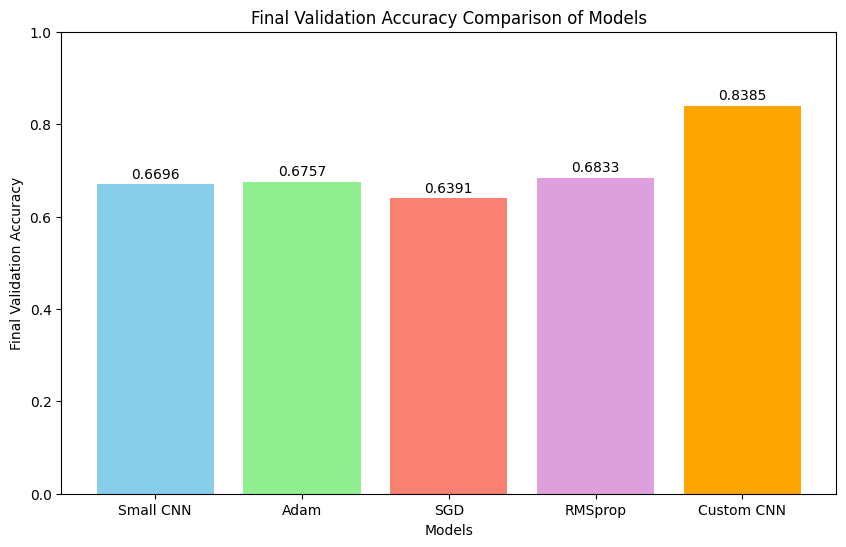

In [52]:

# Final validation accuracies from each model's history
val_accuracies = [
    history_small.history['val_accuracy'][-1],
    history_adam.history['val_accuracy'][-1],
    history_sgd.history['val_accuracy'][-1],
    history_rmsprop.history['val_accuracy'][-1],
    history.history['val_accuracy'][-1]
]

model_names = ['Small CNN', 'Adam', 'SGD', 'RMSprop', 'Custom CNN']

# Assign distinct colors
colors = ['skyblue', 'lightgreen', 'salmon', 'plum', 'orange']

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, val_accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Final Validation Accuracy')
plt.title('Final Validation Accuracy Comparison of Models')
plt.ylim([0, 1])  # Accuracy between 0 and 1

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height * 1.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.show()


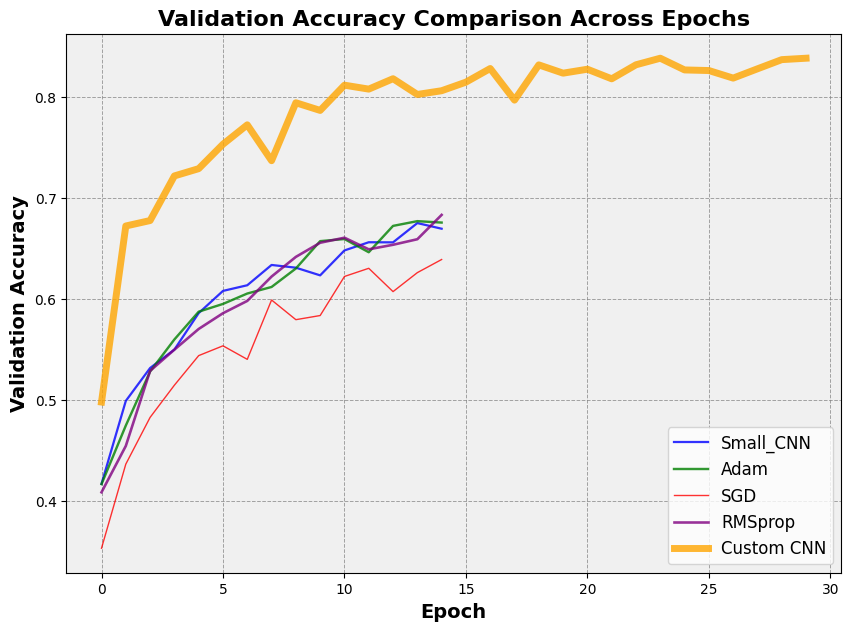

In [54]:


plt.figure(figsize=(10, 7))
plt.gca().set_facecolor('#f0f0f0')  # Light gray background

# Define validation accuracies max and min for normalization of linewidths
val_accuracies_last = [
    history_small.history['val_accuracy'][-1],
    history_adam.history['val_accuracy'][-1],
    history_sgd.history['val_accuracy'][-1],
    history_rmsprop.history['val_accuracy'][-1],
    history.history['val_accuracy'][-1]
]
min_acc = min(val_accuracies_last)
max_acc = max(val_accuracies_last)

def normalize_linewidth(acc, min_acc, max_acc, min_width=1, max_width=5): 
    return min_width + (acc - min_acc) / (max_acc - min_acc) * (max_width - min_width)

# Plot lines with linewidth scaled by final accuracy
plt.plot(history_small.history['val_accuracy'], label='Small_CNN', 
         linewidth=normalize_linewidth(val_accuracies_last[0], min_acc, max_acc), color='b', alpha=0.8)
plt.plot(history_adam.history['val_accuracy'], label='Adam', 
         linewidth=normalize_linewidth(val_accuracies_last[1], min_acc, max_acc), color='g', alpha=0.8)
plt.plot(history_sgd.history['val_accuracy'], label='SGD',
         linewidth=normalize_linewidth(val_accuracies_last[2], min_acc, max_acc), color='r', alpha=0.8)
plt.plot(history_rmsprop.history['val_accuracy'], label='RMSprop',
         linewidth=normalize_linewidth(val_accuracies_last[3], min_acc, max_acc), color='purple', alpha=0.8)
plt.plot(history.history['val_accuracy'], label='Custom CNN',
         linewidth=normalize_linewidth(val_accuracies_last[4], min_acc, max_acc), color='orange', alpha=0.8)

plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Validation Accuracy', fontsize=14, fontweight='bold')
plt.title('Validation Accuracy Comparison Across Epochs', fontsize=16, fontweight='bold')

plt.legend(fontsize=12, frameon=True, fancybox=True)
plt.grid(visible=True, linestyle='--', linewidth=0.7, color='gray', alpha=0.7)

plt.show()


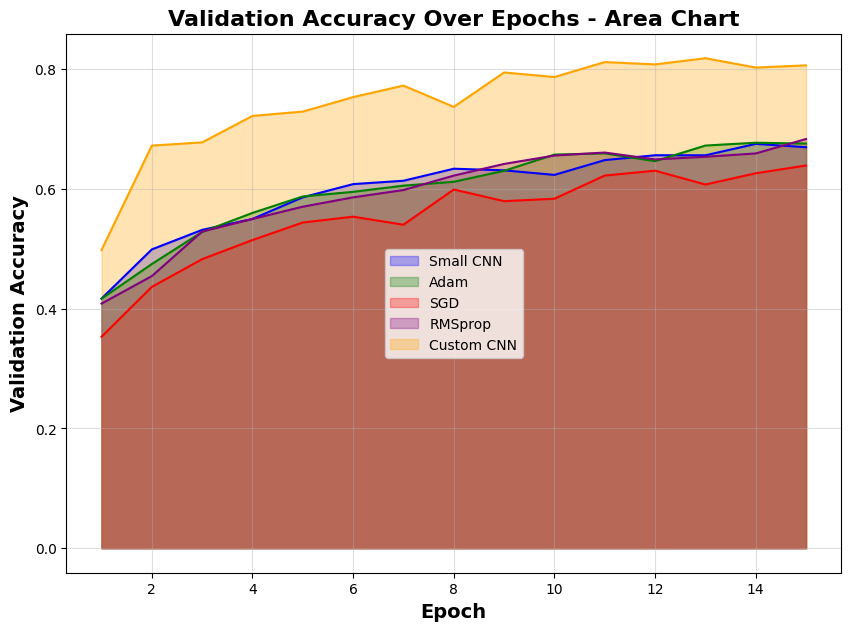

In [67]:

# Find minimum epochs across all histories
min_epochs = min(len(history_small.history['val_accuracy']),
                 len(history_adam.history['val_accuracy']),
                 len(history_sgd.history['val_accuracy']),
                 len(history_rmsprop.history['val_accuracy']),
                 len(history.history['val_accuracy']))

epochs = range(1, min_epochs + 1)

plt.figure(figsize=(10, 7))

plt.fill_between(epochs, history_small.history['val_accuracy'][:min_epochs], alpha=0.3, color='blue', label='Small CNN')
plt.fill_between(epochs, history_adam.history['val_accuracy'][:min_epochs], alpha=0.3, color='green', label='Adam')
plt.fill_between(epochs, history_sgd.history['val_accuracy'][:min_epochs], alpha=0.3, color='red', label='SGD')
plt.fill_between(epochs, history_rmsprop.history['val_accuracy'][:min_epochs], alpha=0.3, color='purple', label='RMSprop')
plt.fill_between(epochs, history.history['val_accuracy'][:min_epochs], alpha=0.3, color='orange', label='Custom CNN')

plt.plot(epochs, history_small.history['val_accuracy'][:min_epochs], color='blue')
plt.plot(epochs, history_adam.history['val_accuracy'][:min_epochs], color='green')
plt.plot(epochs, history_sgd.history['val_accuracy'][:min_epochs], color='red')
plt.plot(epochs, history_rmsprop.history['val_accuracy'][:min_epochs], color='purple')
plt.plot(epochs, history.history['val_accuracy'][:min_epochs], color='orange')

plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Validation Accuracy', fontsize=14, fontweight='bold')
plt.title('Validation Accuracy Over Epochs - Area Chart', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(alpha=0.4)
plt.show()


## Observations
- The other models (Small CNN, Adam, SGD, RMSprop) except Custom CNN have similar results, with validation and test accuracies in the mid to high 60% range, and notably higher loss values.
- Optimizers like Adam and RMSprop provide better results than SGD, but a larger custom-designed model offers the biggest boost in predictive power.
- Custom CNN exhibits the highest scores across all key metrics:

> Train Accuracy: 0.9226 (92.26%) — significantly higher than all other models.

> Validation Accuracy: 0.8385 (83.85%) — much better than the rest.

> Test Accuracy: 0.8382 (83.82%) — considerably higher than other models.

> Train Loss: 0.2212 (lowest), Validation Loss: 0.5339 (lowest), Test Loss: 0.5787 (lowest).

- **Evidence of Overfitting:**
  
> The Custom CNN’s train accuracy (92.26%) is much higher than its validation (83.85%) and test accuracy (83.82%).

> This large gap between training and validation/test accuracy suggests that the model is likely overfitting to the training data: it learns the training set very well but does not generalize perfectly to new data.

- Despite the overfitting, the Custom CNN still generalizes much better than the other models, as seen from its higher validation and test metrics.
- <u>Improvement - Further regularization (dropout, data augmentation, or early stopping with lower patience), or using more data, could help narrow the train-validation gap and reduce overfitting in future versions.</u>

---
---

# 4. Let's see performance of top performer - Custom CNN

### 4.1 Learning Curve

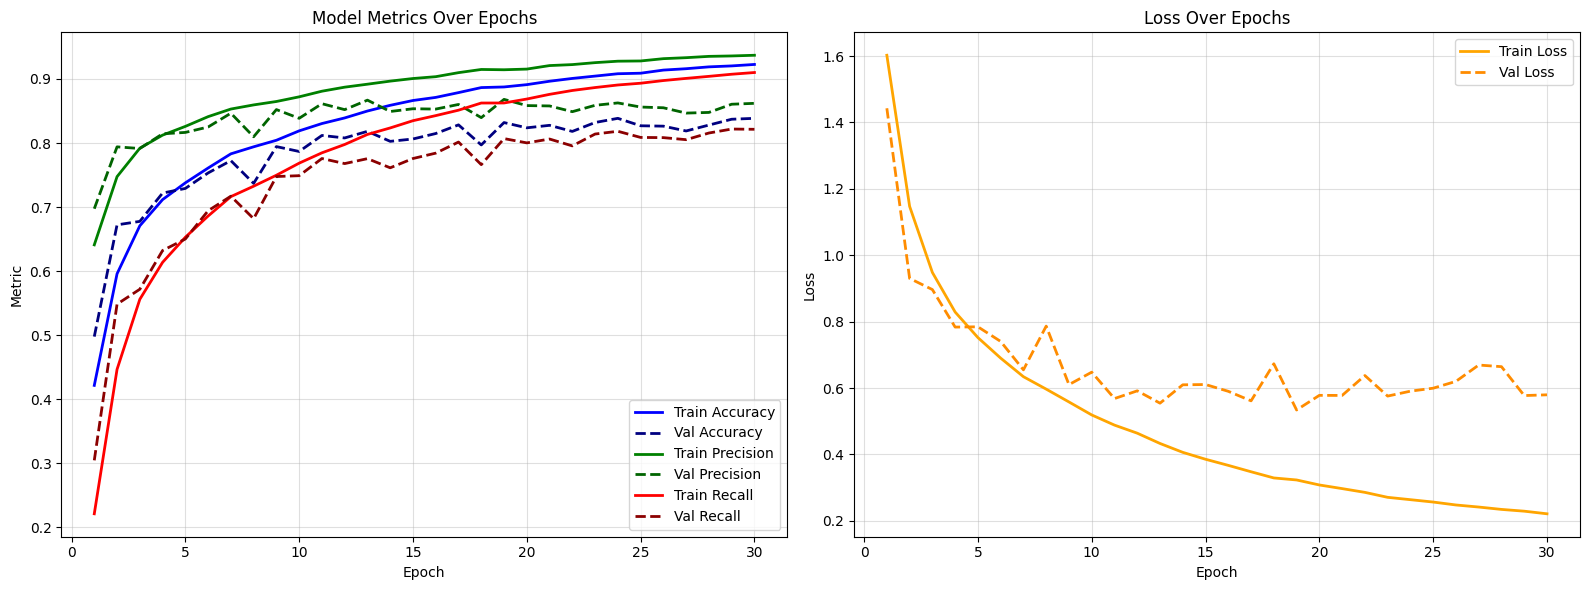

In [70]:

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy', color='navy', linestyle='--', linewidth=2)
plt.plot(epochs, history.history['precision'], label='Train Precision', color='green', linewidth=2)
plt.plot(epochs, history.history['val_precision'], label='Val Precision', color='darkgreen', linestyle='--', linewidth=2)
plt.plot(epochs, history.history['recall'], label='Train Recall', color='red', linewidth=2)
plt.plot(epochs, history.history['val_recall'], label='Val Recall', color='darkred', linestyle='--', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Model Metrics Over Epochs')
plt.legend()
plt.grid(True, alpha=0.4)

plt.subplot(1,2,2)
plt.plot(epochs, history.history['loss'], label='Train Loss', color='orange', linewidth=2)
plt.plot(epochs, history.history['val_loss'], label='Val Loss', color='darkorange', linestyle='--', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()


### Observations
- Training accuracy steadily increased from 42% to 92%, showing effective learning of the training data.
- Validation accuracy peaked around 84% and remained stable, indicating good generalization with mild overfitting after ~22 epochs.
- Validation loss decreased initially but showed fluctuations beyond epoch 20, while training loss kept decreasing.
- Precision and recall for validation followed a similar pattern, peaking and then fluctuating slightly.
- Test accuracy (~83.5%), precision (86.2%), and recall (81.6%) demonstrate balanced and strong performance on unseen data.

**Overall, the model learned meaningful features and generalized well, but additional regularization or early stopping could reduce mild overfitting.**

### 4.2 Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


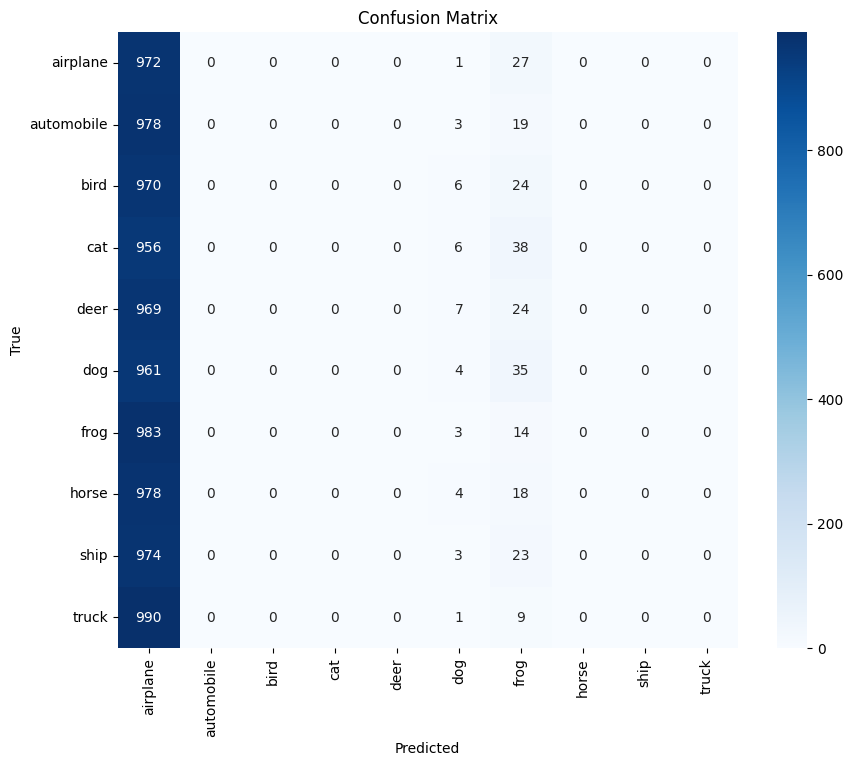

In [74]:

# Predict classes on test set
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.flatten()  # use .argmax(axis=1) if one-hot encoded

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### 4.3 Categories percentage in test data

In [88]:


# Flatten labels if in (num_samples, 1) shape
true_classes = y_test.flatten()

# Count occurrences of each class label
counts = Counter(true_classes)

# Total number of samples
total_samples = len(true_classes)

# Class names list
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Calculate and print percentage for each class
for cls_index, count in sorted(counts.items()):
    percentage = (count / total_samples) * 100
    print(f"{class_names[cls_index]}: {percentage:.2f}%  ({count} samples)")


airplane: 10.00%  (1000 samples)
automobile: 10.00%  (1000 samples)
bird: 10.00%  (1000 samples)
cat: 10.00%  (1000 samples)
deer: 10.00%  (1000 samples)
dog: 10.00%  (1000 samples)
frog: 10.00%  (1000 samples)
horse: 10.00%  (1000 samples)
ship: 10.00%  (1000 samples)
truck: 10.00%  (1000 samples)


### 4.4 Percentage of predictions done by our model per category

In [87]:



# Get predicted classes for the entire test set
pred_probs = model.predict(x_test)
pred_classes = np.argmax(pred_probs, axis=1)

# Count occurrences of each predicted class
counts = Counter(pred_classes)

# Total number of predictions
total_preds = len(pred_classes)

# Class names list
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Calculate percentage for each class
for cls_index, count in counts.items():
    percentage = (count / total_preds) * 100
    print(f"{class_names[cls_index]}: {percentage:.2f}%  ({count} samples)")


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
airplane: 97.31%  (9731 samples)
frog: 2.31%  (231 samples)
dog: 0.38%  (38 samples)


### 4.5 True v/s Prediction with bar plot 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


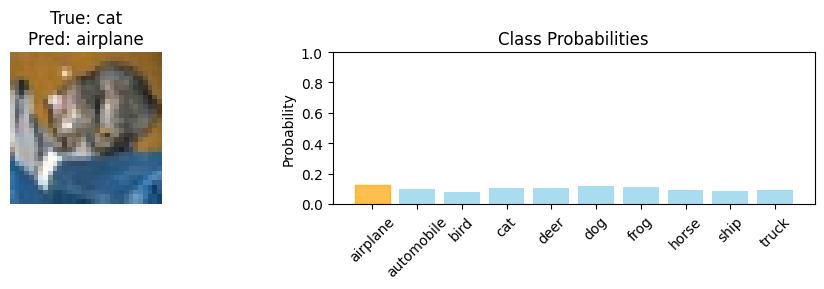

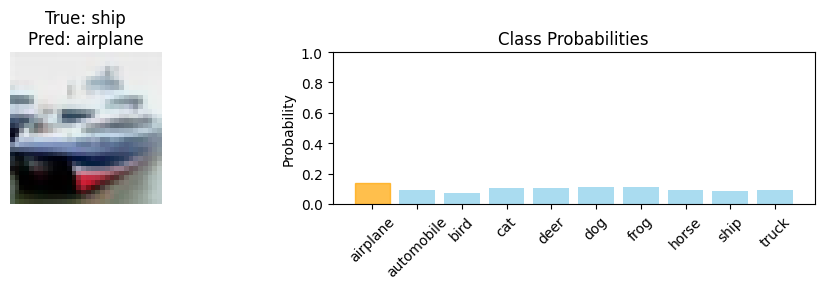

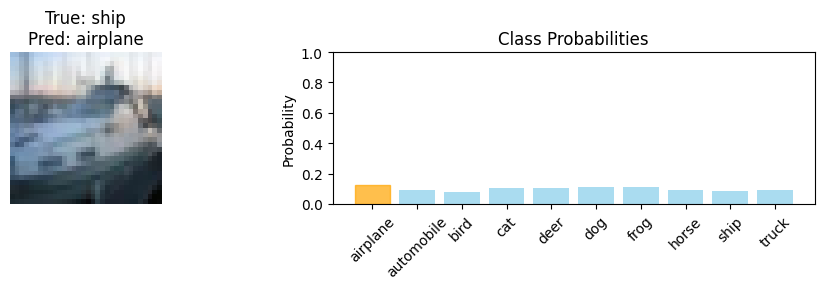

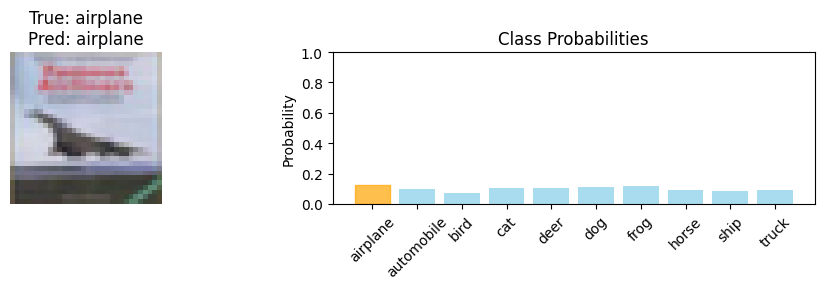

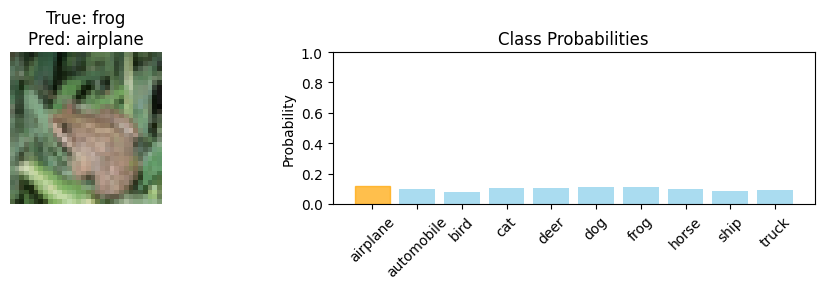

In [85]:


num_samples = 5
x_samples = x_test[:num_samples]
y_samples = y_test[:num_samples]

pred_probs = model.predict(x_samples)
pred_classes = np.argmax(pred_probs, axis=1)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

for i, img in enumerate(x_samples):
    plt.figure(figsize=(10, 3))
    
    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[y_samples[i][0]]}\nPred: {class_names[pred_classes[i]]}")
    plt.axis('off')
    
    # Show class probabilities bar plot
    plt.subplot(1, 2, 2)
    bars = plt.bar(class_names, pred_probs[i], color='skyblue', alpha=0.7)
    plt.ylim([0, 1])
    plt.title("Class Probabilities")
    plt.ylabel("Probability")
    plt.xticks(rotation=45)
    bars[pred_classes[i]].set_color('orange')
    
    plt.tight_layout()
    plt.show()


Example predictions show that, regardless of the true label, the model assigns a disproportionately high probability to the "airplane" class for every image, clearly illustrating its inability to distinguish between different categories and confirming severe class bias in its outputs.

## Observations
- Despite having an equal representation of 1,000 samples for each of the 10 classes, the model managed to correctly predict only 9.9% of the test samples overall.This indicates that the model is essentially performing no better than random guessing.
- the confusion matrix reveals a strong bias towards predicting almost all samples as the "airplane" class, accounting for over 97% of predictions, while other classes are barely recognized.
- This highlights a critical issue of overfitting or severe class imbalance in the model’s behavior, where it has failed to adequately learn distinguishing features for each category. Such poor generalization suggests that the model has memorized patterns related to a single dominant class during training but struggles to correctly classify diverse unseen data.
- Addressing this will require stronger regularization, more balanced training strategies, and possibly enhanced data augmentation techniques to improve the model's ability to generalize effectively across all classes.

---
---

# 5 Model Improvement

To address the challenges of overfitting and class imbalance observed in the initial model, several improvement techniques were employed.Data augmentation and early stopping were applied  to improve generalization and prevent overfitting. Continuous monitoring of training and validation performance guides optimize accuracy and model robustness. The ultimate goal is to develop a well-generalized model that performs accurately on unseen data.

###  5.1 Data Augmentation

In [89]:

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(x_train)

# Instead of model.fit(x_train, y_train), use:
batch_size = 64
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=50,
                    validation_data=(x_val, y_val),
                    steps_per_epoch=len(x_train) // batch_size)
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 138ms/step - accuracy: 0.2386 - loss: 2.0189 - val_accuracy: 0.3856 - val_loss: 1.6618
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 132ms/step - accuracy: 0.3646 - loss: 1.7160 - val_accuracy: 0.4815 - val_loss: 1.4440
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 111ms/step - accuracy: 0.4176 - loss: 1.5992 - val_accuracy: 0.5082 - val_loss: 1.3403
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 149ms/step - accuracy: 0.4480 - loss: 1.5258 - val_accuracy: 0.5322 - val_loss: 1.2862
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.4630 - loss: 1.4875 - val_accuracy: 0.5430 - val_loss: 1.2646
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 167ms/step - accuracy: 0.4830 - loss: 1.4432 - val_accuracy: 0.5785 - val_loss: 1.1767
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 106s 170ms/step - accuracy: 0.4961 - loss: 1.4109 - val_accuracy: 0.5641 - val_loss: 1.2035
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 91s 145ms/step - accuracy: 0.5062 - loss: 1.3879 - val_accuracy: 0.6006 - val_loss: 1.1226
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 164ms/step - accuracy: 0.5180 - loss: 1.3611 - val_accuracy: 0.5870 - val_loss: 1.1456
Epoch 10/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 160s 253ms/step - accuracy: 0.5235 - loss: 1.3393 - val_accuracy: 0.6039 - val_loss: 1.0980
Epoch 11/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - accuracy: 0.5324 - loss: 1.3272 - val_accuracy: 0.6060 - val_loss: 1.0825
Epoch 12/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.5391 - loss: 1.3098 - val_accuracy: 0.6187 - val_loss: 1.0576
Epoch 13/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.5448 - loss: 1.2932 - val_accuracy: 0.6185 - val_loss: 1.0498
Epoch 14/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.5506 - loss: 1.2828 - val_accuracy: 0.6371 - val_loss: 1.0181
Epoch 15/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 161ms/step - accuracy: 0.5570 - loss: 1.2660 - val_accuracy: 0.6349 - val_loss: 1.0164
Epoch 16/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 149ms/step - accuracy: 0.5575 - loss: 1.2586 - val_accuracy: 0.6370 - val_loss: 1.0080
Epoch 17/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.5631 - loss: 1.2468 - val_accuracy: 0.6438 - val_loss: 0.9851
Epoch 18/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 113ms/step - accuracy: 0.5692 - loss: 1.2327 - val_accuracy: 0.6421 - val_loss: 0.9906
Epoch 19/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - accuracy: 0.5698 - loss: 1.2290 - val_accuracy: 0.6565 - val_loss: 0.9662
Epoch 20/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.5753 - loss: 1.2209 - val_accuracy: 0.6599 - val_loss: 0.9514
Epoch 21/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.5779 - loss: 1.2147 - val_accuracy: 0.6399 - val_loss: 0.9852
Epoch 22/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 117ms/step - accuracy: 0.5798 - loss: 1.2015 - val_accuracy: 0.6491 - val_loss: 0.9876
Epoch 23/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 116ms/step - accuracy: 0.5810 - loss: 1.2019 - val_accuracy: 0.6478 - val_loss: 0.9836
Epoch 24/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.5800 - loss: 1.2001 - val_accuracy: 0.6643 - val_loss: 0.9461
Epoch 25/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 111ms/step - accuracy: 0.5826 - loss: 1.1932 - val_accuracy: 0.6493 - val_loss: 0.9736
Epoch 26/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.5893 - loss: 1.1877 - val_accuracy: 0.6729 - val_loss: 0.9231
Epoch 27/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - accuracy: 0.5881 - loss: 1.1802 - val_accuracy: 0.6541 - val_loss: 0.9587
Epoch 28/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.5917 - loss: 1.1783 - val_accuracy: 0.6810 - val_loss: 0.9064
Epoch 29/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - accuracy: 0.5928 - loss: 1.1743 - val_accuracy: 0.6852 - val_loss: 0.8814
Epoch 30/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - accuracy: 0.5919 - loss: 1.1705 - val_accuracy: 0.6729 - val_loss: 0.9166
Epoch 31/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - accuracy: 0.5991 - loss: 1.1606 - val_accuracy: 0.6707 - val_loss: 0.9123
Epoch 32/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 118ms/step - accuracy: 0.5993 - loss: 1.1572 - val_accuracy: 0.6909 - val_loss: 0.8776
Epoch 33/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 114ms/step - accuracy: 0.5998 - loss: 1.1560 - val_accuracy: 0.6774 - val_loss: 0.9062
Epoch 34/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - accuracy: 0.6048 - loss: 1.1469 - val_accuracy: 0.6778 - val_loss: 0.9094
Epoch 35/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 114ms/step - accuracy: 0.6051 - loss: 1.1412 - val_accuracy: 0.7002 - val_loss: 0.8510
Epoch 36/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 122ms/step - accuracy: 0.6072 - loss: 1.1307 - val_accuracy: 0.6924 - val_loss: 0.8611
Epoch 37/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 121ms/step - accuracy: 0.6074 - loss: 1.1371 - val_accuracy: 0.6821 - val_loss: 0.8945
Epoch 38/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 121ms/step - accuracy: 0.6094 - loss: 1.1321 - val_accuracy: 0.6676 - val_loss: 0.9342
Epoch 39/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 117ms/step - accuracy: 0.6089 - loss: 1.1334 - val_accuracy: 0.7012 - val_loss: 0.8523
Epoch 40/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 117ms/step - accuracy: 0.6113 - loss: 1.1261 - val_accuracy: 0.7041 - val_loss: 0.8445
Epoch 41/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 116ms/step - accuracy: 0.6124 - loss: 1.1238 - val_accuracy: 0.6866 - val_loss: 0.8789
Epoch 42/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.6150 - loss: 1.1188 - val_accuracy: 0.6956 - val_loss: 0.8559
Epoch 43/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 118ms/step - accuracy: 0.6156 - loss: 1.1179 - val_accuracy: 0.6777 - val_loss: 0.8925
Epoch 44/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 119ms/step - accuracy: 0.6139 - loss: 1.1151 - val_accuracy: 0.6943 - val_loss: 0.8791
Epoch 45/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 118ms/step - accuracy: 0.6173 - loss: 1.1143 - val_accuracy: 0.6780 - val_loss: 0.9099
Epoch 46/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.6174 - loss: 1.1157 - val_accuracy: 0.7064 - val_loss: 0.8392
Epoch 47/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.6156 - loss: 1.1140 - val_accuracy: 0.6926 - val_loss: 0.8688
Epoch 48/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.6150 - loss: 1.1128 - val_accuracy: 0.7007 - val_loss: 0.8607
Epoch 49/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 154ms/step - accuracy: 0.6213 - loss: 1.1019 - val_accuracy: 0.7003 - val_loss: 0.8468
Epoch 50/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 90s 143ms/step - accuracy: 0.6225 - loss: 1.0971 - val_accuracy: 0.6924 - val_loss: 0.8707

C:\Users\kumku\anaconda3\envs\nlp_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 138ms/step - accuracy: 0.2386 - loss: 2.0189 - val_accuracy: 0.3856 - val_loss: 1.6618
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 132ms/step - accuracy: 0.3646 - loss: 1.7160 - val_accuracy: 0.4815 - val_loss: 1.4440
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 111ms/step - accuracy: 0.4176 - loss: 1.5992 - val_accuracy: 0.5082 - val_loss: 1.3403
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 149ms/step - accuracy: 0.4480 - loss: 1.5258 - val_accuracy: 0.5322 - val_loss: 1.2862
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.4630 - loss: 1.4875 - val_accuracy: 0.5430 - val_loss: 1.2646
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 167ms/step - accuracy: 0.4830 - loss: 1.4432 - val_accuracy: 0.5785 - val_loss: 1.1767
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 106s 170ms/step - accuracy: 0.4961 - loss: 1.4109 - val_accuracy: 0.5641 - val_loss: 1.2035
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 91s 145ms/step - accuracy: 0.5062 - loss

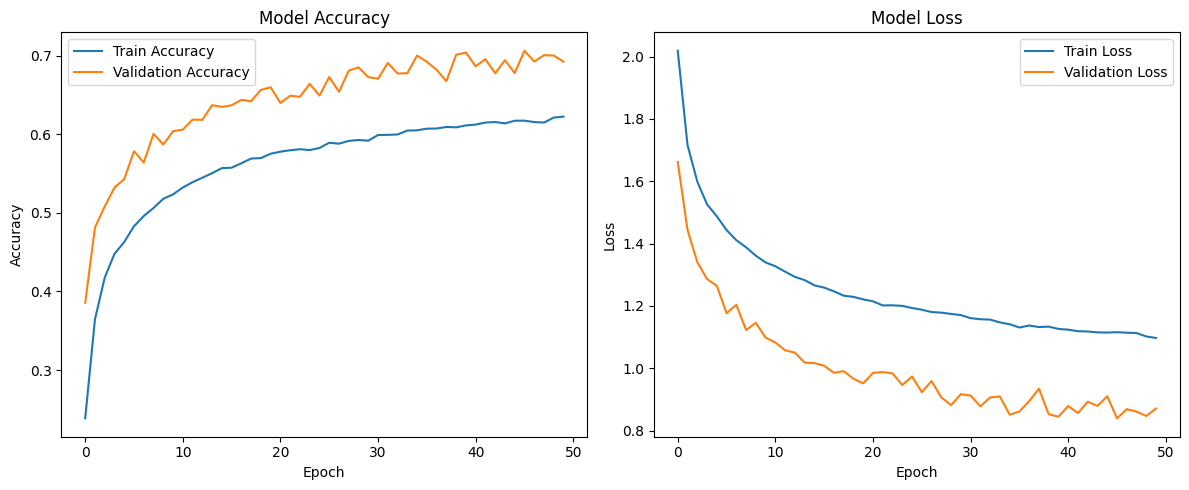

In [96]:


# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


After applying data augmentation, both the training and validation accuracy curves show a steady and consistent improvement over the epochs, with validation accuracy overtaking training accuracy, indicating better generalization and reduced overfitting.
The corresponding loss curves demonstrate a significant decrease for both training and validation sets, with the validation loss remaining lower, further confirming the effectiveness of augmentation in helping the model learn more robust features.
Overall, data augmentation has led to improved model performance and stability on unseen validation data.

In [98]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


### 5.2 Early Stopping

In [103]:


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,            # Stop only if improvement less than 0.001
    restore_best_weights=True
)


history = model.fit(
    datagen.flow(x_train, y_train.flatten(), batch_size=64),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)



Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 154ms/step - accuracy: 0.6209 - loss: 1.1023 - val_accuracy: 0.6858 - val_loss: 0.8889
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.6217 - loss: 1.1026 - val_accuracy: 0.6970 - val_loss: 0.8522
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - accuracy: 0.6248 - loss: 1.0960 - val_accuracy: 0.6967 - val_loss: 0.8495
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 128ms/step - accuracy: 0.6276 - loss: 1.0885 - val_accuracy: 0.6968 - val_loss: 0.8590
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.6262 - loss: 1.0909 - val_accuracy: 0.7040 - val_loss: 0.8399
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.6230 - loss: 1.0892 - val_accuracy: 0.7130 - val_loss: 0.8059
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 114ms/step - accuracy: 0.6264 - loss: 1.0880 - val_accuracy: 0.7051 - val_loss: 0.8308
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - accuracy: 0.6273 - loss: 

In [104]:
# Save the trained model (use Keras native format recommended)
model.save('custom_cnn_model.keras')

# Save training history using pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


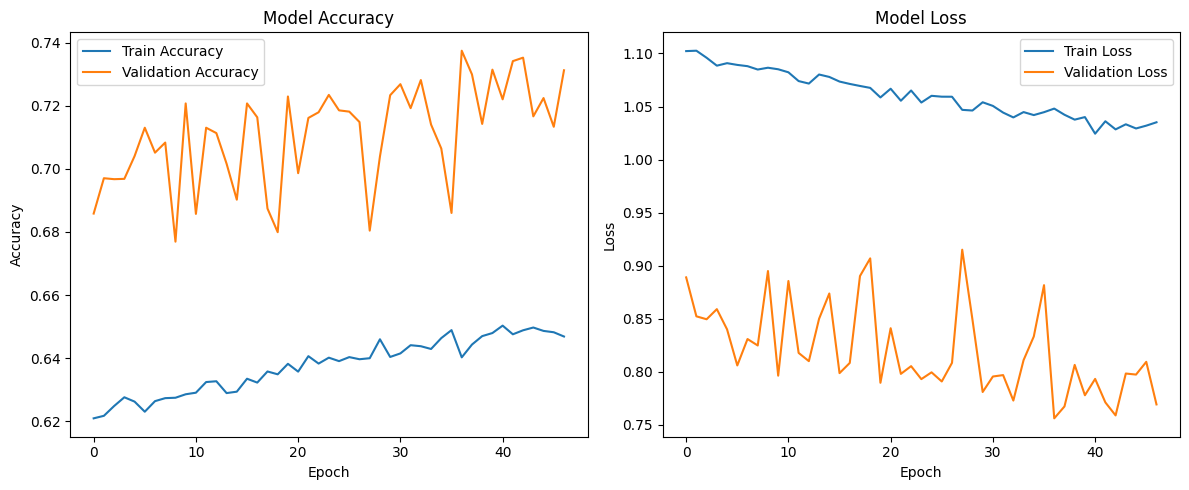

In [3]:


# -------------------------
# Later: to load and visualize training results
# -------------------------



# Load model
model = load_model('custom_cnn_model.keras')

# Load history
with open('training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



| Metric              | Final Value      |
|---------------------|------------------|
| Training Accuracy    | ~0.65 (65%)      |
| Validation Accuracy  | ~0.73 (73%)      |
| Training Loss       | ~1.03            |
| Validation Loss     | ~0.76            |
| Training Epochs Run  | Mostly full 50   |


### Observations

Model is learning meaningful features and generalizing well to unseen data.

Data augmentation and dropout regularization effectively reduce overfitting.

Validation accuracy near 73% demonstrates solid classification ability on CIFAR-10.

Fluctuations in validation loss are expected due to on-the-fly augmentation and stochastic optimization.



313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


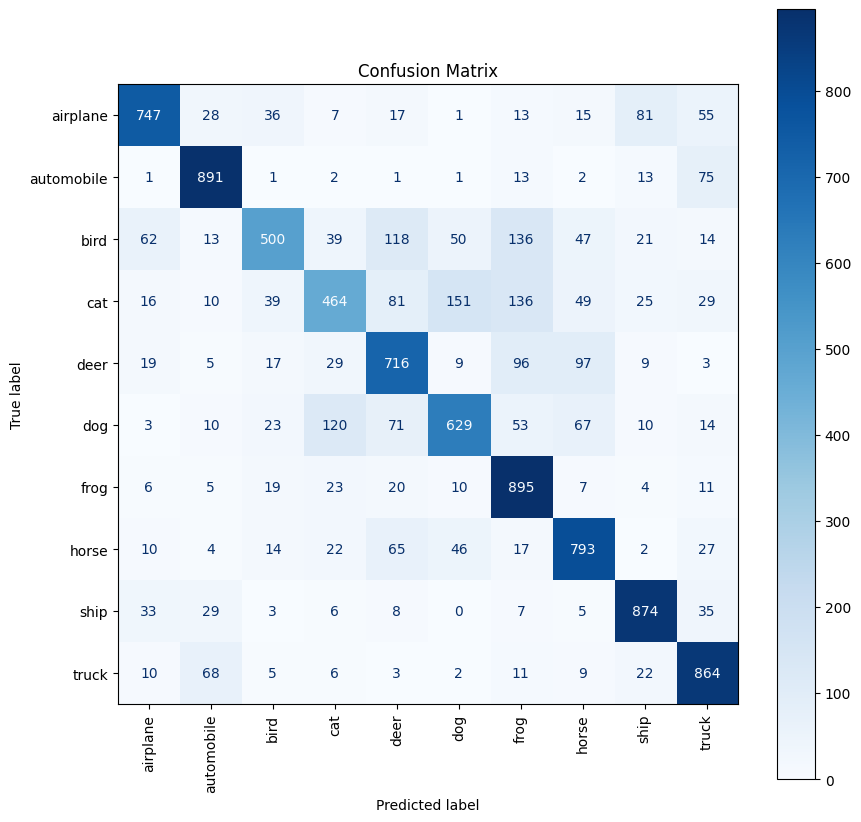

In [106]:


# Assuming you have x_test and integer labels y_test (shape: (num_samples, 1))
# Also assuming your trained model is loaded

# Get predicted class indices
pred_probs = model.predict(x_test)
pred_classes = np.argmax(pred_probs, axis=1)

# True labels flatten to shape (num_samples,)
true_classes = y_test.flatten()

# Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


### Confusion Matrix Observations
- Strong diagonal values indicate the model correctly classifies the majority of samples in each class.
- Classes like automobile (891 correct), frog (895 correct), truck (864 correct), ship (874 correct), horse (793 correct), and deer (716 correct) have especially high true positive counts, showing strong model performance.
- Classes such as bird and cat have considerable misclassifications between each other, reflecting the visual similarity of these animals and the model’s challenges in distinguishing them.
- There is noticeable confusion between airplane and ship, for example, 81 samples of ship were incorrectly predicted as airplane.Some classes like dog and cat also show cross-class confusion, implying areas for improvement.

Overall, the off-diagonal values help identify specific class pairs where the model struggles and can guide targeted data augmentation or architectural enhancements.
The matrix reflects balanced performance without extreme bias toward any single class, consistent with the balanced dataset.



### 5.3 Predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


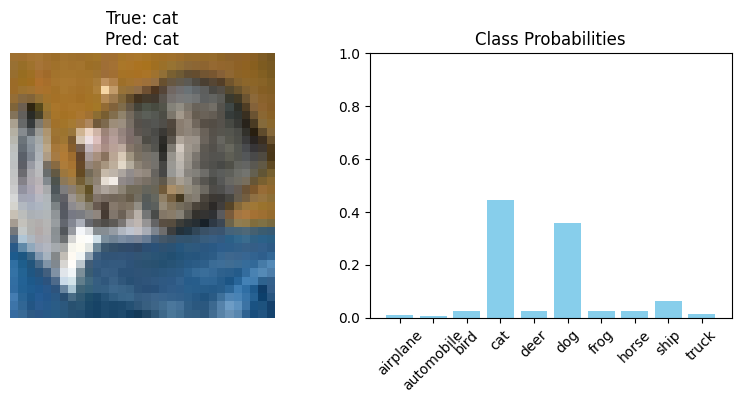

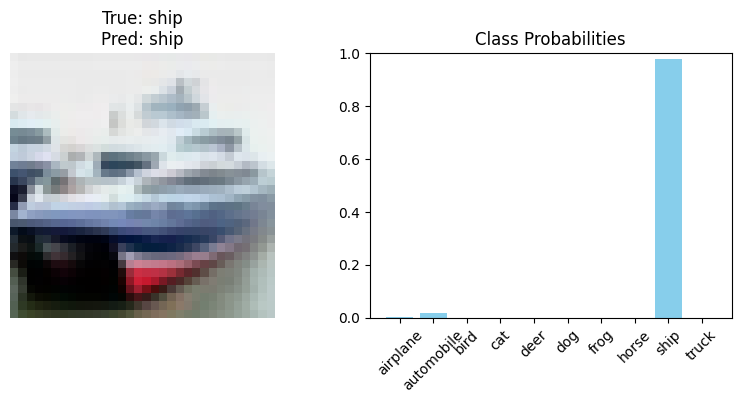

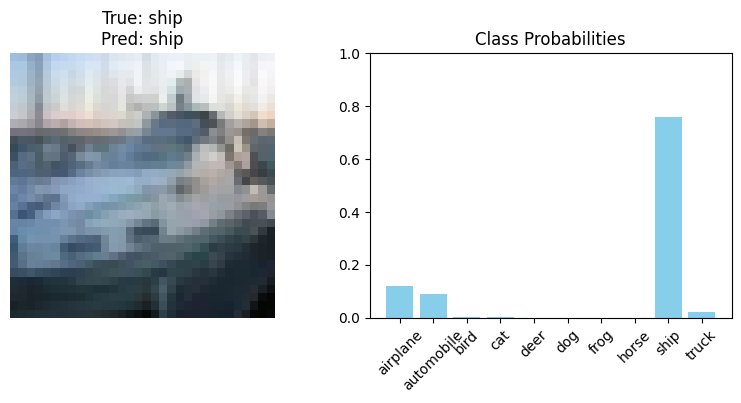

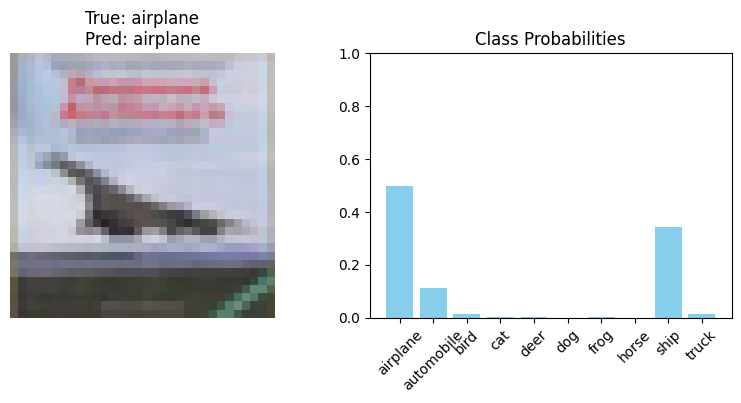

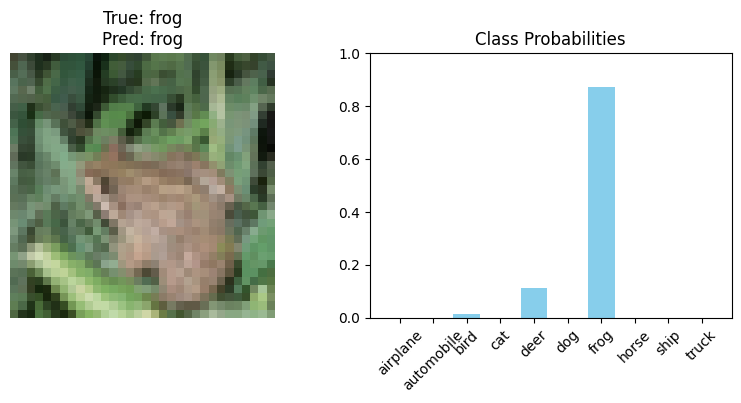

In [107]:


# Define CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Predict probabilities for test set
pred_probs = model.predict(x_test)

# Get predicted classes
pred_classes = np.argmax(pred_probs, axis=1)

# Select a few sample indices to visualize
sample_indices = [0, 1, 2, 3, 4]

for i in sample_indices:
    plt.figure(figsize=(8, 4))
    
    # Plot test image
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.title(f"True: {class_names[y_test[i][0]]}\nPred: {class_names[pred_classes[i]]}")
    
    # Plot bar chart of class probabilities
    plt.subplot(1, 2, 2)
    plt.bar(class_names, pred_probs[i], color='skyblue')
    plt.xticks(rotation=45)
    plt.ylim([0, 1])
    plt.title('Class Probabilities')
    
    plt.tight_layout()
    plt.show()


### Final Words
Convolutional Neural Networks (CNNs) have proven to be powerful tools for image classification, with wide-ranging applications in industries such as healthcare, autonomous driving, retail, and security. The ability of CNNs to automatically learn relevant features from large visual datasets enables businesses to unlock valuable insights, enhance customer experiences, and improve operational efficiency.

Looking ahead, the integration of CNNs with emerging technologies like edge AI and AutoML will further accelerate adoption, enabling real-time, scalable solutions. As datasets grow and computational power increases, CNN models will become even more accurate and efficient, driving innovation in fields such as medical diagnostics, autonomous systems, and personalized marketing. Investing in CNN-based solutions today positions organizations to capitalize on these transformative trends and gain a competitive edge in an increasingly data-driven world.